<a href="https://colab.research.google.com/github/jhonnylte/Projectile-Motion/blob/main/ProjectileMotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from math import radians
import sympy
import tensorflow as tf

from tensorflow import keras
print(tf.__version__)

2.14.0


In [ ]:
# Criação da tabela de dados
o=10
m=0.02
g=9.8
v0=15
b=1
y=0
while b <= 5:
  while o <= 89:
    while m <= 0.09:
      while v0 <= 25:
        #Resolução da equação afim de encontrar o valor de X de acordo com as entradas
        x = sympy.Symbol('x')
        equacao = sympy.Eq(sympy.tan(radians(o))*x - ((g)/(2*(v0**2)*(sympy.cos(radians(o)))**2)*(x**2)) - ((b*g)/(3*m*(v0**3)*(sympy.cos(radians(o))**3)))*(x**3), y)
        alcance = sympy.solve(equacao, x)
        tabela = pd.concat([tabela, pd.DataFrame([[m, o, v0, b, alcance[2]]], columns=['Massa', 'Ângulo', 'V0', 'B', 'Alcance'])])
        v0+=1
      v0=15
      m+=0.01
    m=0.01
    v0=15
    o+=1
  m=0.01
  v=15
  o=10
  b+=0.2

In [ ]:
from pandas.io.excel import ExcelWriter
with pd.ExcelWriter("tabela_lancamentos.xlsx", mode="w", engine="openpyxl", ) as writer:
  tabela.to_excel(index=False, engine='openpyxl', excel_writer=writer)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving tabela_lancamentos.xlsx to tabela_lancamentos.xlsx


In [ ]:
raw_dataset = pd.read_excel('tabela_lancamentos.xlsx', engine='openpyxl')

In [ ]:
dataset = raw_dataset.copy()

In [ ]:
dataset.tail()

Massa  Ângulo  V0    B   Alcance
158384   0.09      89  21  4.8  0.122183
158385   0.09      89  22  4.8  0.131136
158386   0.09      89  23  4.8  0.140300
158387   0.09      89  24  4.8  0.149670
158388   0.09      89  25  4.8  0.159243

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0) #frac default = 0.8
test_dataset = dataset.drop(train_dataset.index)

In [ ]:
train_dataset.columns = ['Mass', 'Angle', 'Initial velocity', 'B', 'Range']

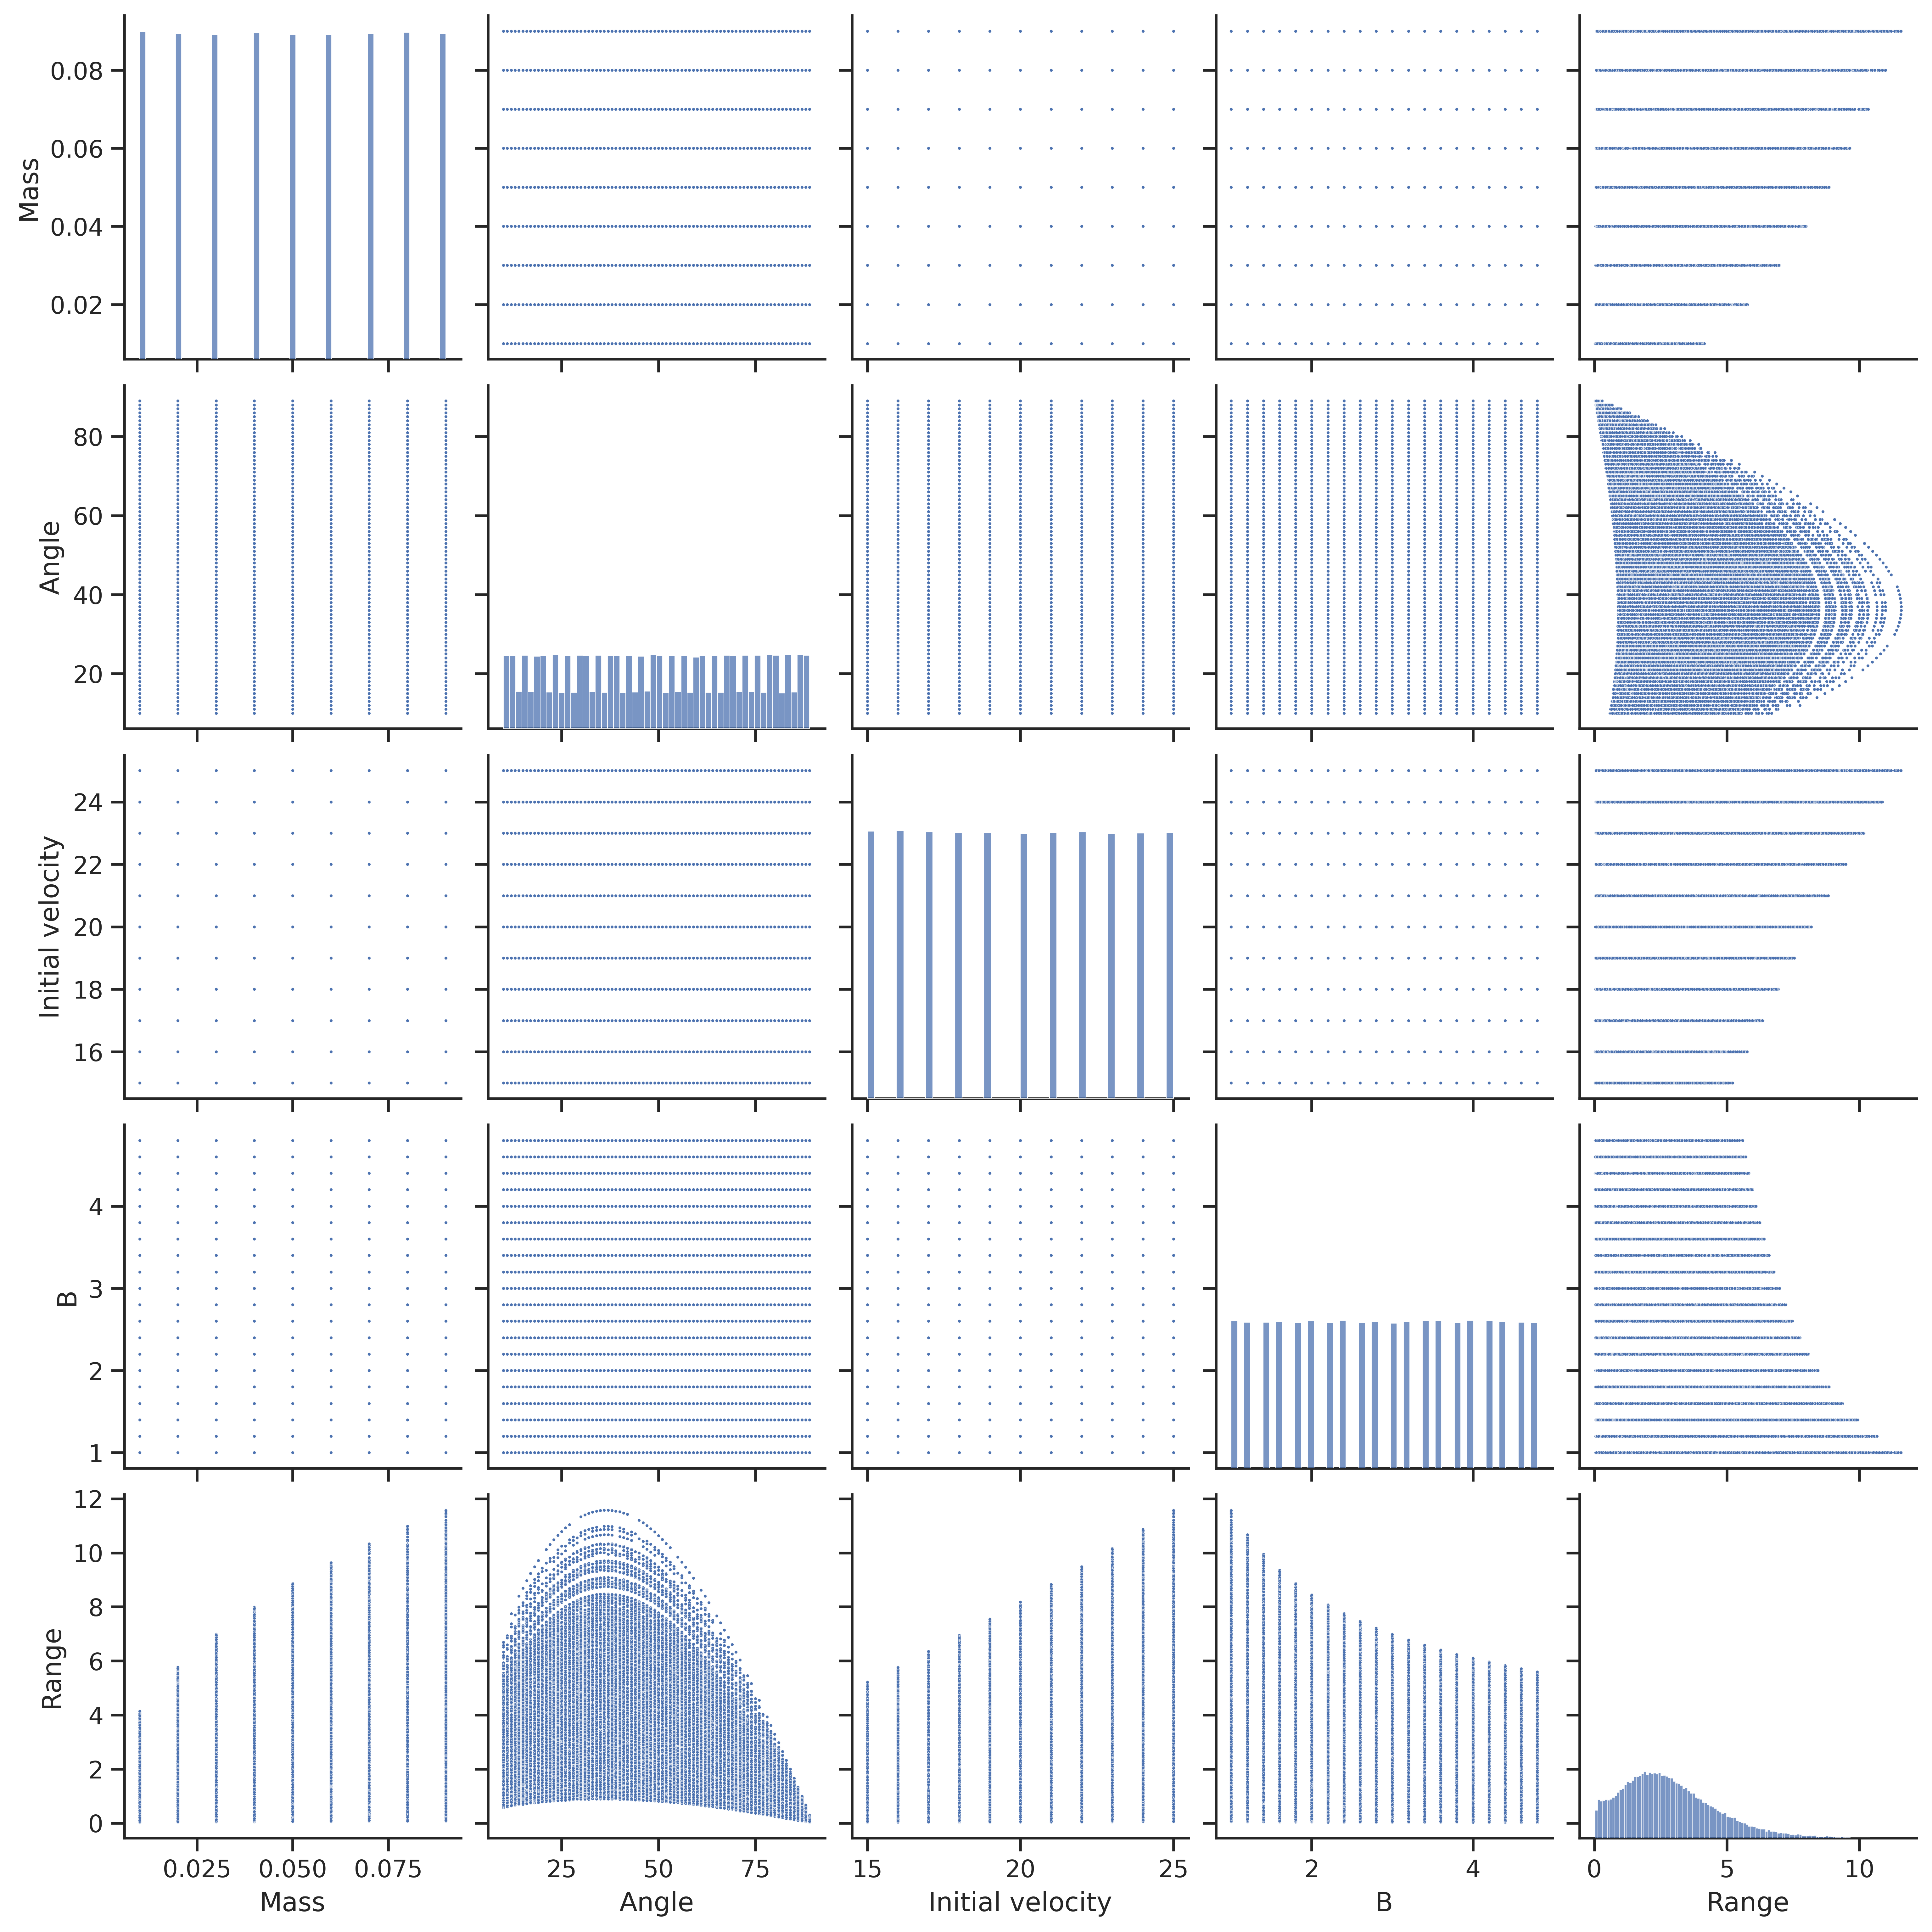

In [ ]:

sns.set(rc={'figure.dpi':500, 'savefig.dpi':500})
sns.set_style(style='ticks')
pairplot = sns.pairplot(train_dataset[['Mass', 'Angle', 'Initial velocity', 'B', 'Range']], plot_kws={'s':2}, diag_kind='auto' )


# Exiba o gráfico

plt.savefig("pairplotHR500.png")


<Figure size 6000x3600 with 0 Axes>

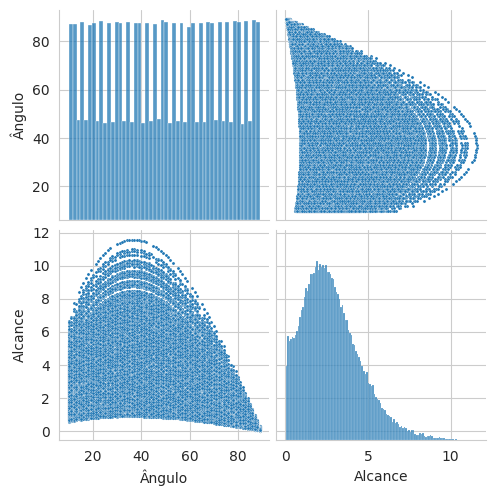

In [ ]:
plt.figure(figsize=(10, 6), dpi=600)
sns.pairplot(train_dataset[['Ângulo', 'Alcance']], plot_kws={'s':5}, diag_kind='auto')

In [ ]:
sns.set_style('whitegrid')

In [ ]:
train_dataset.columns

Index(['Massa', 'Ângulo', 'V0', 'B', 'Alcance'], dtype='object')

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("Alcance")
train_stats = train_stats.transpose()
train_stats

count       mean        std    min    25%    50%    75%    max
Massa   126711.0   0.049994   0.025841   0.01   0.03   0.05   0.07   0.09
Ângulo  126711.0  49.528478  23.103671  10.00  30.00  50.00  70.00  89.00
V0      126711.0  19.993134   3.164114  15.00  17.00  20.00  23.00  25.00
B       126711.0   2.900088   1.152973   1.00   2.00   3.00   4.00   4.80

In [ ]:
train_labels = train_dataset.pop('Alcance')
test_labels = test_dataset.pop('Alcance')

In [ ]:
train_dataset.columns

Index(['Massa', 'Ângulo', 'V0', 'B'], dtype='object')

In [ ]:
train_stats['mean']

Massa      0.049994
Ângulo    49.528478
V0        19.993134
B          2.900088
Name: mean, dtype: float64

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [ ]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(100, activation='relu', input_shape=[len(train_dataset.keys())]),
    keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               500       
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 601 (2.35 KB)
Trainable params: 601 (2.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 209ms/step


array([[ 0.37104985],
       [ 0.37333977],
       [-0.03858592],
       [ 0.06627545],
       [-0.04550306],
       [-0.01587379],
       [-0.00632686],
       [ 0.05601752],
       [ 0.08347331],
       [ 0.05716818]], dtype=float32)

In [ ]:
# Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss       mae       mse  val_loss   val_mae   val_mse  epoch
995  0.000362  0.013705  0.000362  0.000218  0.010484  0.000218    995
996  0.000362  0.013678  0.000362  0.000280  0.012544  0.000280    996
997  0.000359  0.013704  0.000359  0.000526  0.017620  0.000526    997
998  0.000362  0.013628  0.000362  0.000611  0.020310  0.000611    998
999  0.000361  0.013650  0.000361  0.000223  0.011018  0.000223    999

In [ ]:
model.save('projectileMotion.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


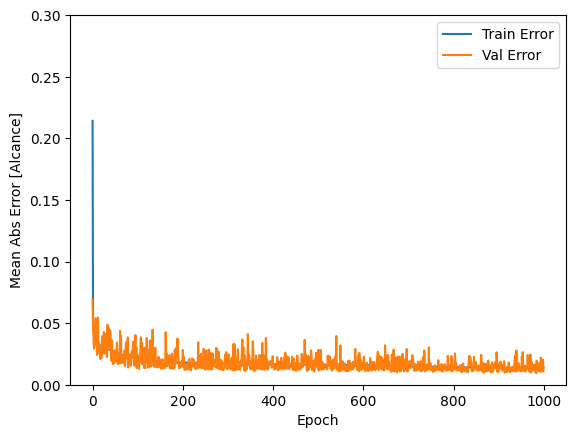

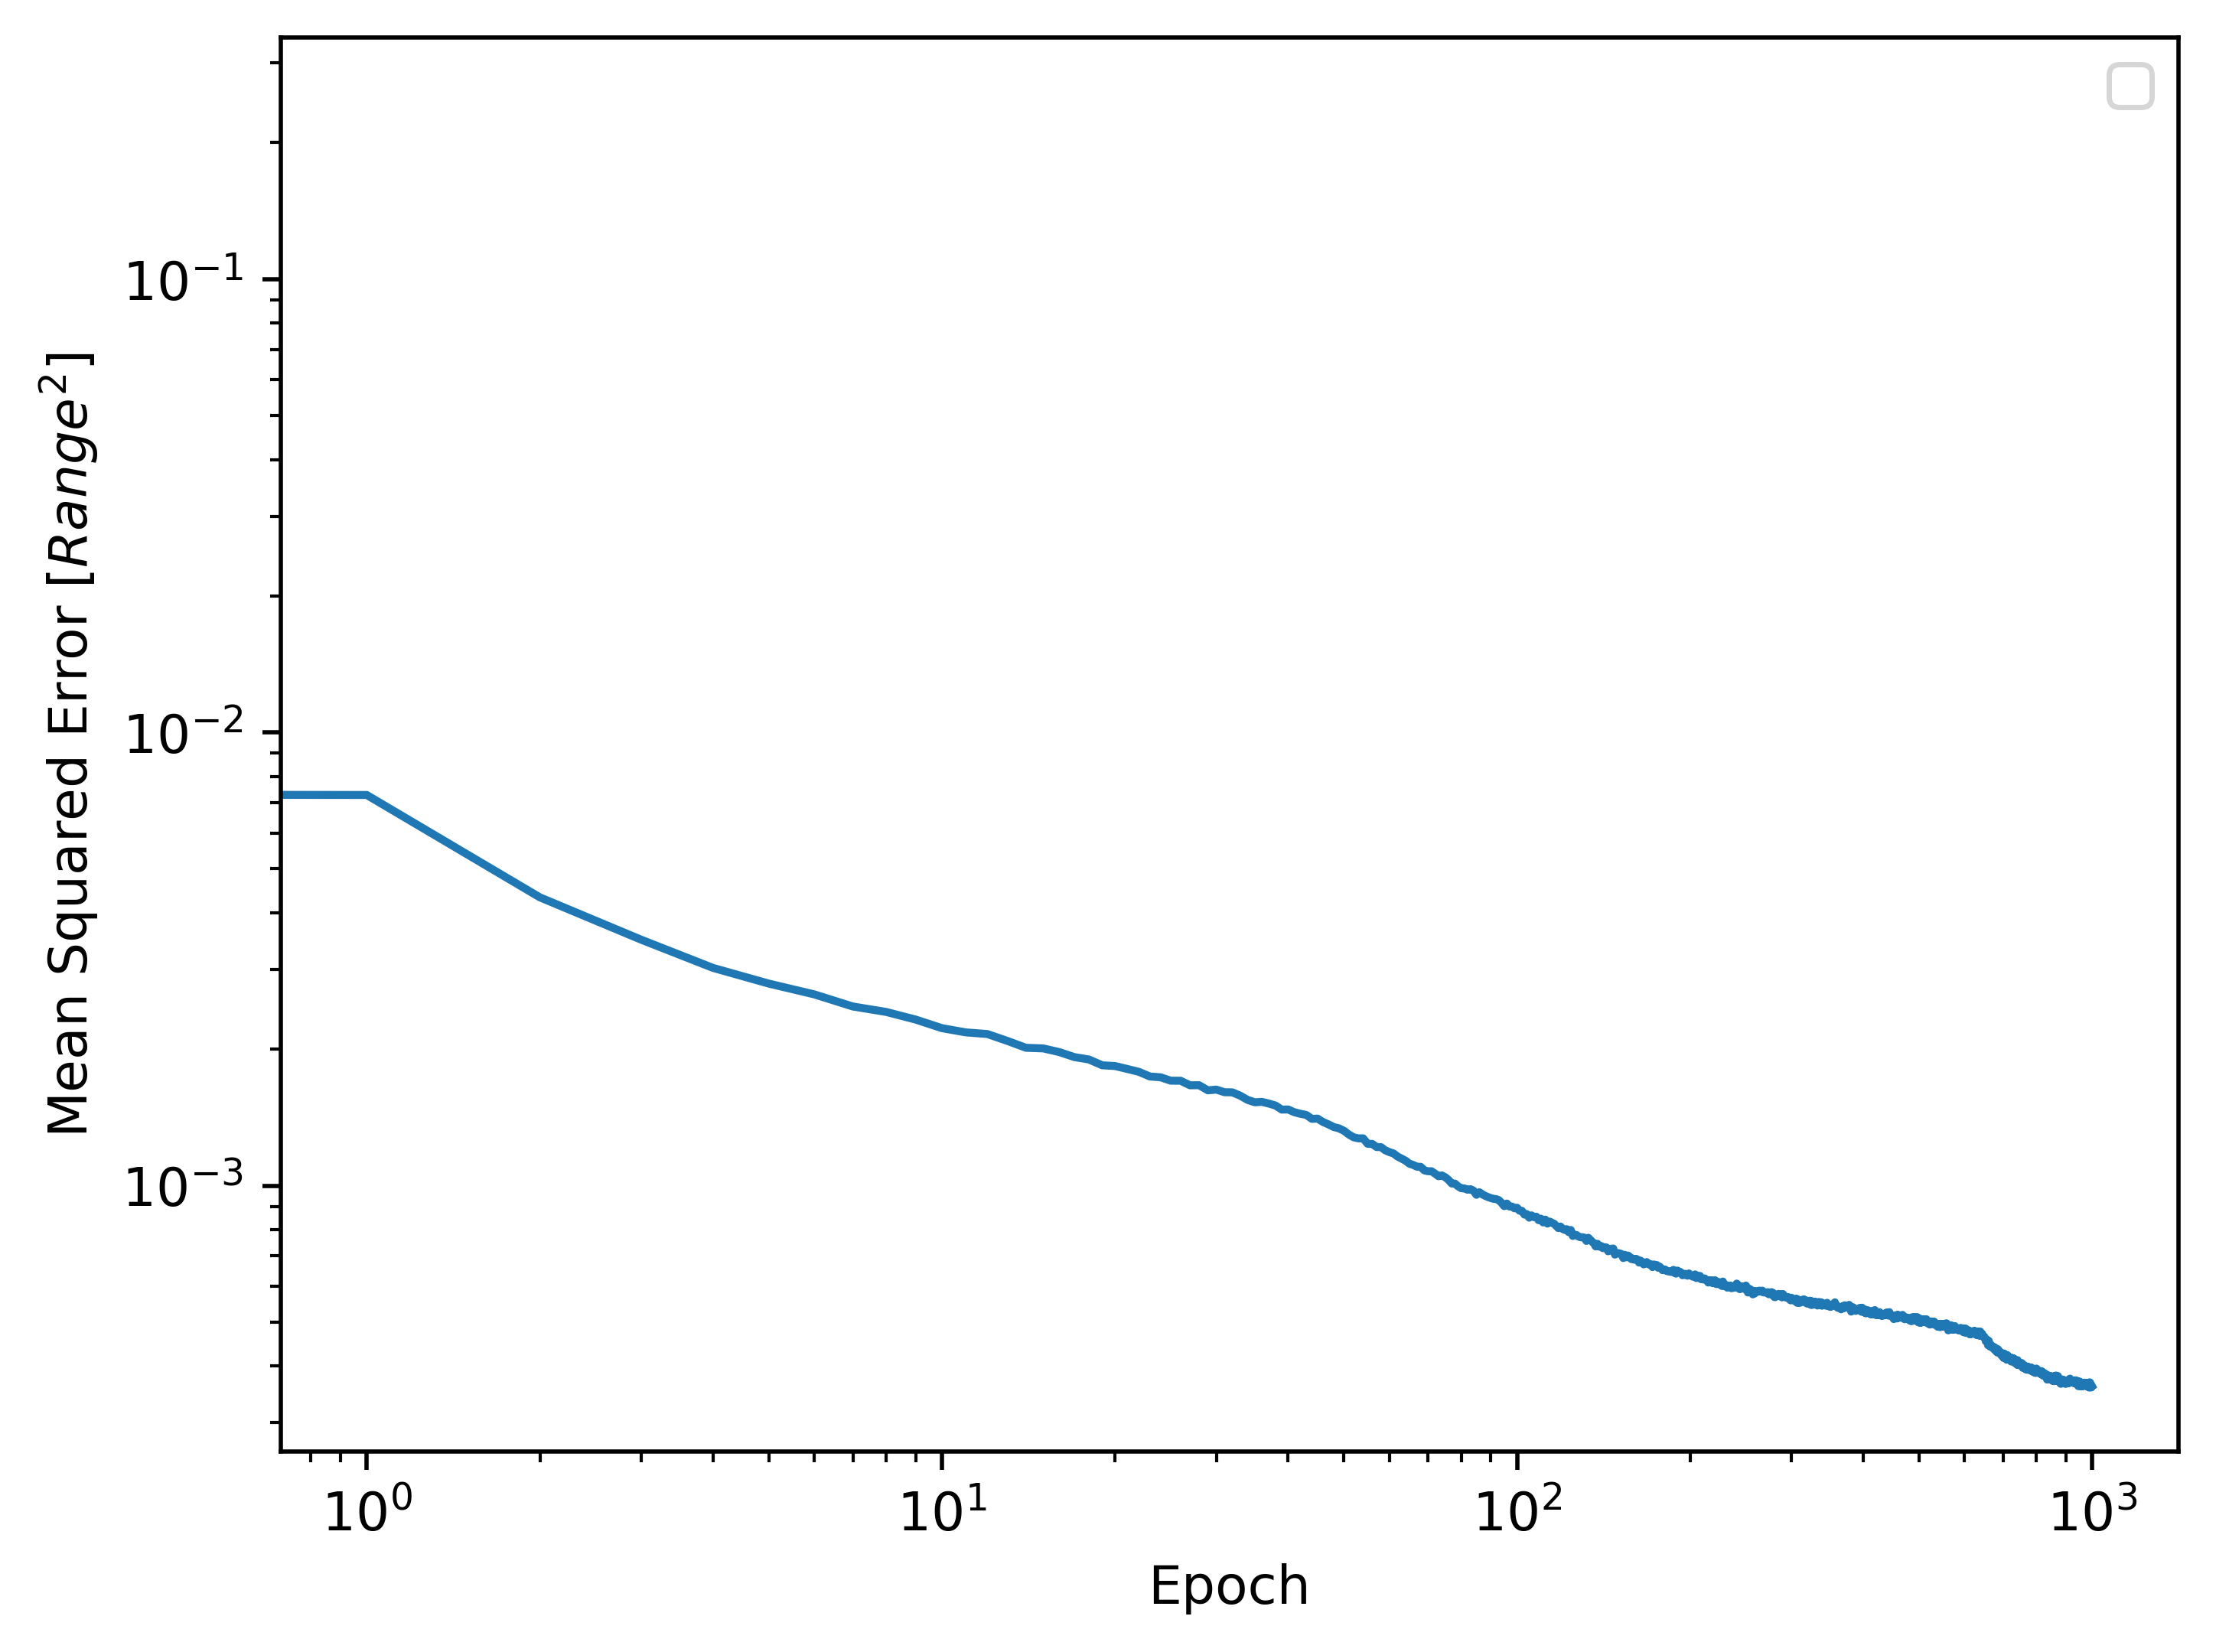

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Alcance]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,0.30])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error [$Range^2$]')
  plt.loglog(hist['epoch'], hist['mse'],
           )
  #plt.plot(hist['epoch'], hist['val_mse'],
 #          label = 'Val Error')
  #plt.ylim([0,0.30])
  plt.gcf().set_dpi(500)
  plt.savefig('mseloglog500.png', dpi=500)
  plt.legend()
  plt.show()


plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Alcance".format(mae))
print("Testing set Mean Square Error: {:5.8f} Alcance".format(mse))

990/990 - 1s - loss: 2.2418e-04 - mae: 0.0110 - mse: 2.2418e-04 - 1s/epoch - 1ms/step
Testing set Mean Abs Error:  0.01 Alcance
Testing set Mean Square Error: 0.00022418 Alcance


990/990 [==============================] - 2s 2ms/step


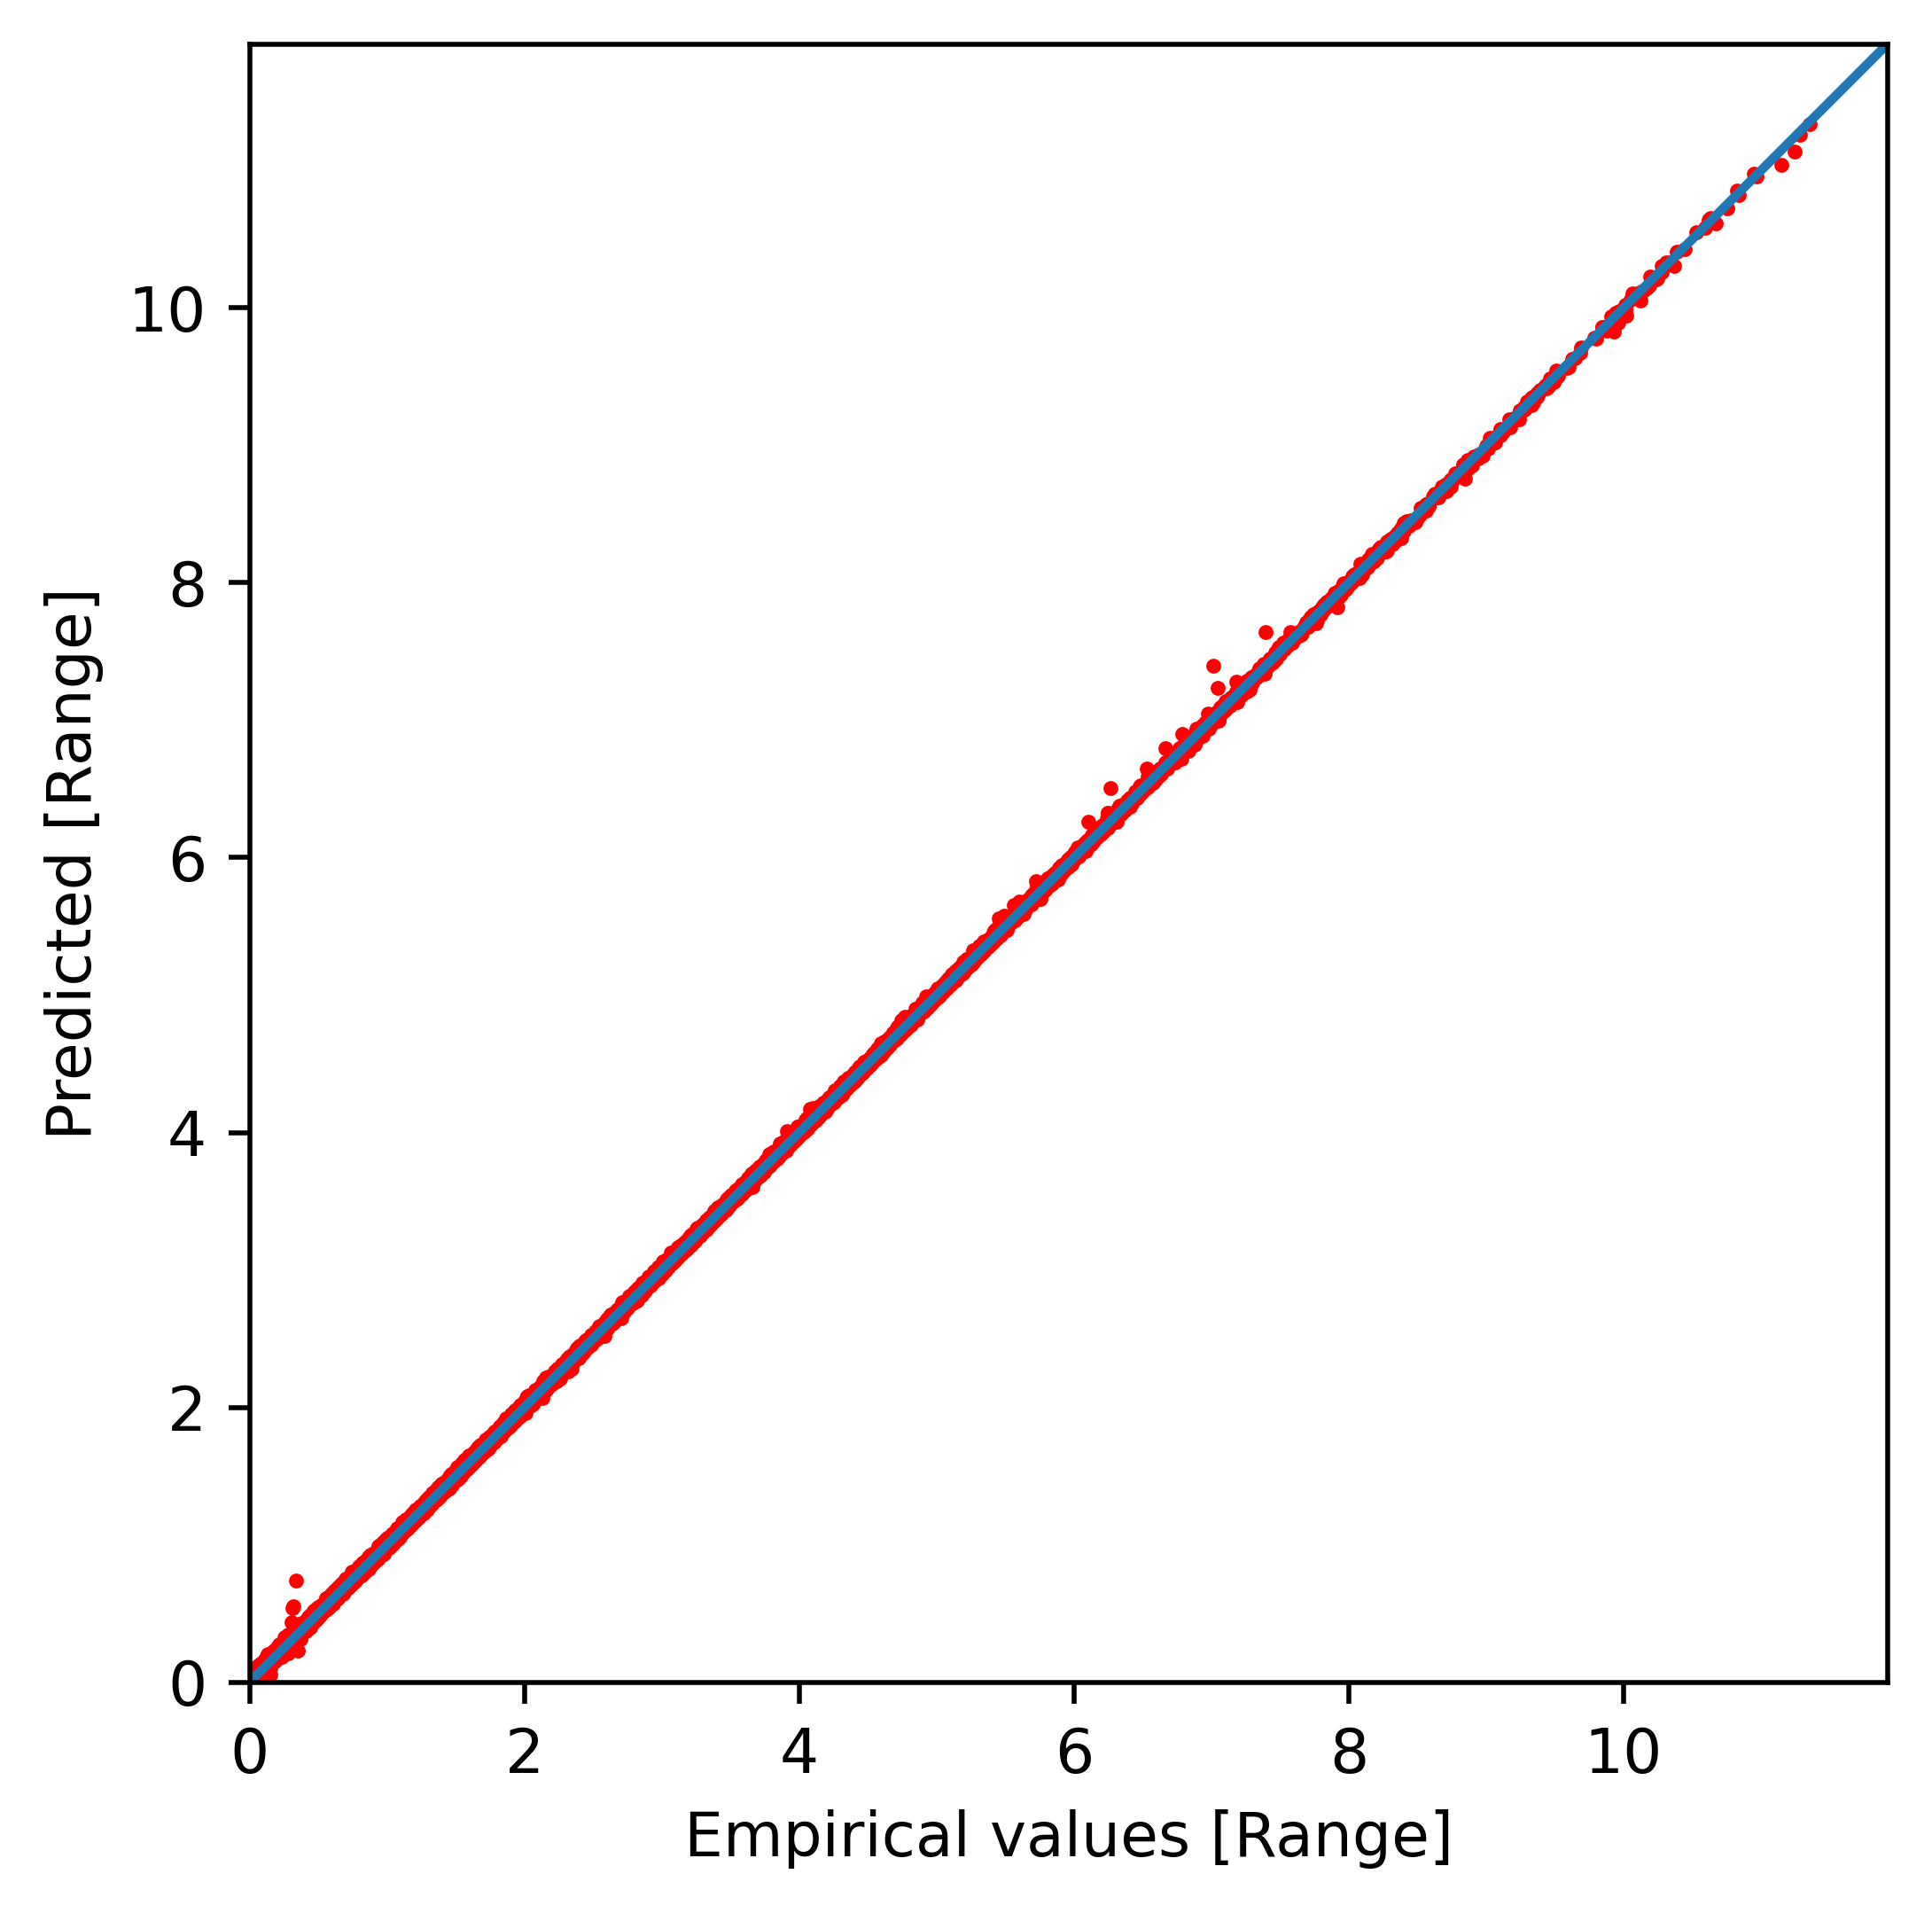

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions, s=2, color='red')
plt.gcf().set_dpi(500)

plt.xlabel('Empirical values [Range]')
plt.ylabel('Predicted [Range]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.savefig('finalgraph500.png', dpi=500)

In [ ]:
from sklearn.metrics import mean_squared_error

# Cálculo do RMSE
mean_squared_error(test_labels, test_predictions, squared=False)

0.022073166803239938

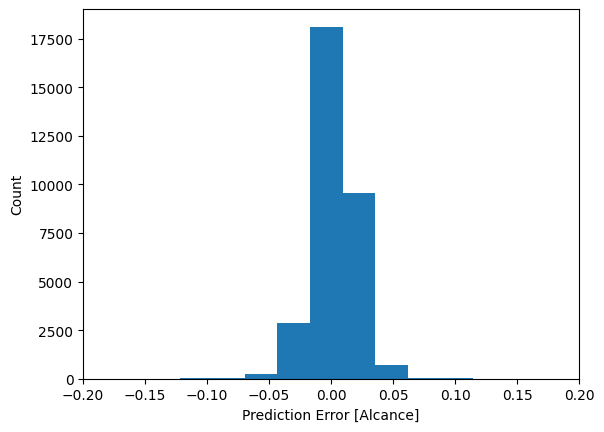

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Alcance]")
plt.xlim([-0.2,0.2])
_ = plt.ylabel("Count")

In [ ]:
model.predict([list(norm([0.01, 16, 18, 2]))])

1/1 [==============================] - 0s 65ms/step


array([[1.4968607]], dtype=float32)

In [ ]:
model.save('lancamento.h5')

In [ ]:
carga = keras.models.load_model('lancamento.h5')

In [ ]:
carga.predict([list(norm([0.01, 16, 18, 2]))])

1/1 [==============================] - 0s 75ms/step


array([[1.4968607]], dtype=float32)

In [ ]:
tabelaAmostra = dataset.sample(6, ignore_index=True)

In [ ]:
tabelaAmostra

Massa  Ângulo  V0    B   Alcance Previsto
0   0.04      29  23  2.8  4.231865     None
1   0.01      57  19  1.4  1.876964     None
2   0.05      87  23  1.2  0.615001     None
3   0.09      68  19  3.0  2.707171     None
4   0.08      18  24  3.6  4.760582     None
5   0.09      57  19  3.6  3.424881     None

In [ ]:
tabelaAmostra['Previsto'] = None

In [ ]:
for i in range(len(tabelaAmostra)):
  tabelaAmostra['Previsto'][i] = model.predict([list(norm([tabelaAmostra['Massa'][i], tabelaAmostra['Ângulo'][i], tabelaAmostra['V0'][i], tabelaAmostra['B'][i]]))])
  tabelaAmostra['Previsto'][i] = tabelaAmostra['Previsto'][i][0][0]

1/1 [==============================] - 0s 35ms/step


<ipython-input-116-83e9aaf7e205>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabelaAmostra['Previsto'][i] = model.predict([list(norm([tabelaAmostra['Massa'][i], tabelaAmostra['Ângulo'][i], tabelaAmostra['V0'][i], tabelaAmostra['B'][i]]))])
<ipython-input-116-83e9aaf7e205>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabelaAmostra['Previsto'][i] = tabelaAmostra['Previsto'][i][0][0]


1/1 [==============================] - 0s 35ms/step


In [ ]:
tabelaAmostra

Massa  Ângulo  V0    B   Alcance  Previsto
0   0.04      29  23  2.8  4.231865  4.242689
1   0.01      57  19  1.4  1.876964  1.886901
2   0.05      87  23  1.2  0.615001  0.679726
3   0.09      68  19  3.0  2.707171  2.725363
4   0.08      18  24  3.6  4.760582  4.760784
5   0.09      57  19  3.6  3.424881  3.418013

In [ ]:
tabelaAmostra.to_excel('tabelaAmostras.xlsx', index=False, float_format="%.6f")

In [ ]:
display(history.history)

{'loss': [0.2751094400882721,
  0.007969011552631855,
  0.00446906266734004,
  0.0034195685293525457,
  0.0029546774458140135,
  0.0027457191608846188,
  0.0025404703337699175,
  0.00240545766428113,
  0.00233286852017045,
  0.0022262949496507645,
  0.002188413869589567,
  0.0021133259870111942,
  0.0021066090557724237,
  0.002062363550066948,
  0.002028502756729722,
  0.0019614999182522297,
  0.0019166270503774285,
  0.0018998919986188412,
  0.0018712339224293828,
  0.0018103793263435364,
  0.0017894799821078777,
  0.001746256137266755,
  0.0017093828646466136,
  0.0016653096536174417,
  0.0016457036836072803,
  0.0016065731178969145,
  0.0015682530356571078,
  0.0015520186861976981,
  0.0015417024260386825,
  0.00150376430246979,
  0.001487977453507483,
  0.0014683451736345887,
  0.0014369935961440206,
  0.0014242228353396058,
  0.0014106485759839416,
  0.00139244191814214,
  0.0013972228625789285,
  0.001375691033899784,
  0.001365679781883955,
  0.0013438733294606209,
  0.001336044